In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    # c1~c4是每条路径的输出通道数
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inception,self).__init__(**kwargs)
        # 线路1,单1x1卷积层
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        # 线路2,1x1卷积层后接3x3卷积层
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        # 线路3,1x1卷积层后接5x5卷积层
        self.p3_1=nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        # 线路4,3x3最大池化层后接1x1卷积层
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1,p2,p3,p4),dim=1)

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(192,64,(96,128),(16,32),32),
    Inception(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(480,192,(96,208),(16,48),64),
    Inception(512,160,(112,224),(24,64),64),
    Inception(512,128,(128,256),(24,64),64),
    Inception(512,112,(144,288),(32,64),64),
    Inception(528,256,(160,320),(32,128),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(832,256,(160,320),(32,128),128),
    Inception(832,384,(192,384),(48,128),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

X=torch.rand(size=(1,1,96,96))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 64, 48, 48])
ReLU output shape:	 torch.Size([1, 64, 48, 48])
MaxPool2d output shape:	 torch.Size([1, 64, 24, 24])
Conv2d output shape:	 torch.Size([1, 64, 24, 24])
ReLU output shape:	 torch.Size([1, 64, 24, 24])
Conv2d output shape:	 torch.Size([1, 192, 24, 24])
ReLU output shape:	 torch.Size([1, 192, 24, 24])
MaxPool2d output shape:	 torch.Size([1, 192, 12, 12])
Inception output shape:	 torch.Size([1, 256, 12, 12])
Inception output shape:	 torch.Size([1, 480, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 480, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 512, 6, 6])
Inception output shape:	 torch.Size([1, 528, 6, 6])
Inception output shape:	 torch.Size([1, 832, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 832, 3, 3])
Inception output shape:	 torch.Size([1, 832, 3, 3])
Inception output shape:	 torch.Size([1, 1024, 3, 3])
AdaptiveAvgPool2d ou

In [3]:
import netron

X=torch.rand(size=(1,1,96,96))
modeldata='../data/googlenet.pth'
torch.onnx.export(net,X,modeldata)
netron.start(modeldata)

Serving '../data/googlenet.pth' at http://localhost:8080


('localhost', 8080)

loss 0.248, train acc 0.906, test acc 0.892
1773.6 examples/sec on cuda:0


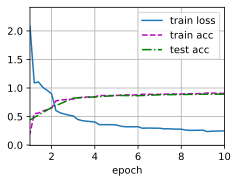

In [3]:
lr,num_epochs,batch_size=0.1,10,128
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

Exercises: GoogLeNet的后续版本

添加批量规范化层

loss 0.086, train acc 0.967, test acc 0.910
1623.9 examples/sec on cuda:0


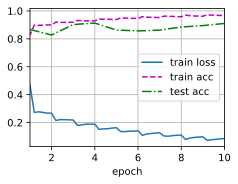

In [4]:
class BNInception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(BNInception,self).__init__(**kwargs)
        self.p1_1=nn.Sequential(nn.Conv2d(in_channels,c1,kernel_size=1),nn.BatchNorm2d(c1))
        self.p2_1=nn.Sequential(nn.Conv2d(in_channels,c2[0],kernel_size=1),nn.BatchNorm2d(c2[0]))
        self.p2_2=nn.Sequential(nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1),nn.BatchNorm2d(c2[1]))
        self.p3_1=nn.Sequential(nn.Conv2d(in_channels,c3[0],kernel_size=1),nn.BatchNorm2d(c3[0]))
        self.p3_2=nn.Sequential(nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2),nn.BatchNorm2d(c3[1]))
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Sequential(nn.Conv2d(in_channels,c4,kernel_size=1),nn.BatchNorm2d(c4))
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1,p2,p3,p4),dim=1)

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.BatchNorm2d(192),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    BNInception(192,64,(96,128),(16,32),32),
    BNInception(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    BNInception(480,192,(96,208),(16,48),64),
    BNInception(512,160,(112,224),(24,64),64),
    BNInception(512,128,(128,256),(24,64),64),
    BNInception(512,112,(144,288),(32,64),64),
    BNInception(528,256,(160,320),(32,128),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    BNInception(832,256,(160,320),(32,128),128),
    BNInception(832,384,(192,384),(48,128),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

对Inception模块进行调整 (Inception v2)

(Note: 容易梯度爆炸,应该是参数选取问题？精度也没有明显提升)

loss 0.261, train acc 0.901, test acc 0.889
1446.7 examples/sec on cuda:0


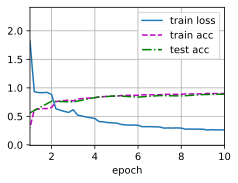

In [8]:
class Inceptionv2(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(Inceptionv2,self).__init__(**kwargs)
        # 线路1,单1x1卷积层
        self.p1_1=nn.Conv2d(in_channels,c1,kernel_size=1)
        # 线路2.1,2.2,1x1卷积层后接1x3卷积层与3x1卷积层
        self.p2_1=nn.Conv2d(in_channels,c2[0],kernel_size=1)
        self.p2_2_1=nn.Conv2d(c2[0],c2[1],kernel_size=(1,3),padding=(0,1))
        self.p2_2_2=nn.Conv2d(c2[0],c2[1],kernel_size=(3,1),padding=(1,0))
        # 线路3.1,3.2,1x1卷积层后接3x3卷积层后接1x3卷积层与3x1卷积层
        self.p3_1=nn.Conv2d(in_channels,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=3,padding=1)
        self.p3_3_1=nn.Conv2d(c3[1],c3[2],kernel_size=(1,3),padding=(0,1))
        self.p3_3_2=nn.Conv2d(c3[1],c3[2],kernel_size=(3,1),padding=(1,0))
        # 线路4,3x3最大池化层后接1x1卷积层
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_channels,c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2_1=F.relu(self.p2_2_1(F.relu(self.p2_1(x))))
        p2_2=F.relu(self.p2_2_2(F.relu(self.p2_1(x))))
        p3_1=F.relu(self.p3_3_1(F.relu(self.p3_2(F.relu(self.p3_1(x))))))
        p3_2=F.relu(self.p3_3_2(F.relu(self.p3_2(F.relu(self.p3_1(x))))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1,p2_1,p2_2,p3_1,p3_2,p4),dim=1)

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inceptionv2(192,64,(96,64),(16,32,16),32),
    Inceptionv2(256,128,(128,96),(32,96,48),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inceptionv2(480,192,(96,104),(16,48,24),64),
    Inceptionv2(512,160,(112,112),(24,64,32),64),
    Inceptionv2(512,128,(128,128),(24,64,32),64),
    Inceptionv2(512,112,(144,144),(32,64,32),64),
    Inceptionv2(528,256,(160,160),(32,128,64),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inceptionv2(832,256,(160,160),(32,128,64),128),
    Inceptionv2(832,384,(192,192),(48,128,64),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

标签平滑正则化

loss 0.703, train acc 0.905, test acc 0.885
1779.8 examples/sec on cuda:0


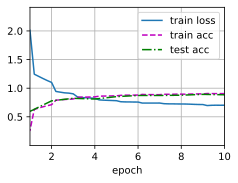

In [13]:
class LabelSmoothing(nn.Module):
    """使用标签平滑的交叉熵损失函数"""
    def __init__(self,smoothing=0.0):
        super(LabelSmoothing,self).__init__()
        self.confidence=1.0-smoothing
        self.smoothing=smoothing  # 平滑参数ε
    def forward(self,x,target):
        logprobs=torch.nn.functional.log_softmax(x,dim=-1)
        nll_loss=-logprobs.gather(dim=-1,index=target.unsqueeze(1))
        nll_loss=nll_loss.squeeze(1)
        smooth_loss=-logprobs.mean(dim=-1)
        loss=self.confidence*nll_loss+self.smoothing*smooth_loss
        return loss.mean()

def train_ls(net,train_iter,test_iter,num_epochs,lr,device):
    def init_weights(m):
        if type(m)==nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    loss=LabelSmoothing(0.1)    # 标签平滑参数ε=0.1
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],legend=['train loss','train acc','test acc'])
    timer,num_batches=d2l.Timer(),len(train_iter)
    for epoch in range(num_epochs):
        metric=d2l.Accumulator(3)
        net.train()
        for i,(X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X,y=X.to(device),y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
            timer.stop()
            train_l=metric[0]/metric[2]
            train_acc=metric[1]/metric[2]
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches,(train_l,train_acc,None))
        test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(device)}')

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(192,64,(96,128),(16,32),32),
    Inception(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(480,192,(96,208),(16,48),64),
    Inception(512,160,(112,224),(24,64),64),
    Inception(512,128,(128,256),(24,64),64),
    Inception(512,112,(144,288),(32,64),64),
    Inception(528,256,(160,320),(32,128),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    Inception(832,256,(160,320),(32,128),128),
    Inception(832,384,(192,384),(48,128),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

train_ls(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

残差连接

loss 0.133, train acc 0.950, test acc 0.881
1267.5 examples/sec on cuda:0


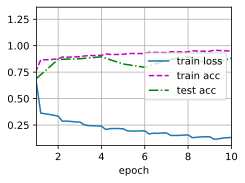

In [16]:
class InceptionRes(nn.Module):
    # 网络结构图见https://zhuanlan.zhihu.com/p/194382937,这里的实现没有考虑调整参数的形式
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(InceptionRes,self).__init__(**kwargs)
        self.p1_1=nn.Sequential(nn.Conv2d(in_channels,c1,kernel_size=1),nn.BatchNorm2d(c1))
        self.p2_1=nn.Sequential(nn.Conv2d(in_channels,c2[0],kernel_size=1),nn.BatchNorm2d(c2[0]))
        self.p2_2=nn.Sequential(nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1),nn.BatchNorm2d(c2[1]))
        self.p3_1=nn.Sequential(nn.Conv2d(in_channels,c3[0],kernel_size=1),nn.BatchNorm2d(c3[0]))
        self.p3_2=nn.Sequential(nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2),nn.BatchNorm2d(c3[1]))
        # 去除池化层，将前三个线路的输出合并通过一个1x1卷积层后与块输入相加得到块输出
        self.conv1=nn.Conv2d(c1+c2[1]+c3[1],c1+c2[1]+c3[1]+c4,kernel_size=1)
        self.conv2=nn.Conv2d(in_channels,c1+c2[1]+c3[1]+c4,kernel_size=1)
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        y=self.conv1(torch.cat((p1,p2,p3),dim=1))+self.conv2(x)
        return F.relu(y)

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    InceptionRes(192,64,(96,128),(16,32),32),
    InceptionRes(256,128,(128,192),(32,96),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    InceptionRes(480,192,(96,208),(16,48),64),
    InceptionRes(512,160,(112,224),(24,64),64),
    InceptionRes(512,128,(128,256),(24,64),64),
    InceptionRes(512,112,(144,288),(32,64),64),
    InceptionRes(528,256,(160,320),(32,128),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    InceptionRes(832,256,(160,320),(32,128),128),
    InceptionRes(832,384,(192,384),(48,128),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

全部组合

loss 0.623, train acc 0.951, test acc 0.896
1024.0 examples/sec on cuda:0


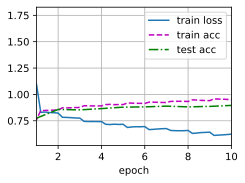

In [19]:
class MyInception(nn.Module):
    def __init__(self,in_channels,c1,c2,c3,c4,**kwargs):
        super(MyInception,self).__init__(**kwargs)
        self.p1_1=nn.Sequential(nn.Conv2d(in_channels,c1,kernel_size=1),nn.BatchNorm2d(c1))
        self.p2_1=nn.Sequential(nn.Conv2d(in_channels,c2[0],kernel_size=1),nn.BatchNorm2d(c2[0]))
        self.p2_2_1=nn.Sequential(nn.Conv2d(c2[0],c2[1],kernel_size=(1,3),padding=(0,1)),nn.BatchNorm2d(c2[1]))
        self.p2_2_2=nn.Sequential(nn.Conv2d(c2[0],c2[1],kernel_size=(3,1),padding=(1,0)),nn.BatchNorm2d(c2[1]))
        self.p3_1=nn.Sequential(nn.Conv2d(in_channels,c3[0],kernel_size=1),nn.BatchNorm2d(c3[0]))
        self.p3_2=nn.Sequential(nn.Conv2d(c3[0],c3[1],kernel_size=3,padding=1),nn.BatchNorm2d(c3[1]))
        self.p3_3_1=nn.Sequential(nn.Conv2d(c3[1],c3[2],kernel_size=(1,3),padding=(0,1)),nn.BatchNorm2d(c3[2]))
        self.p3_3_2=nn.Sequential(nn.Conv2d(c3[1],c3[2],kernel_size=(3,1),padding=(1,0)),nn.BatchNorm2d(c3[2]))
        self.conv1=nn.Sequential(nn.Conv2d(c1+2*c2[1]+2*c3[2],c1+2*c2[1]+2*c3[2]+c4,kernel_size=1),nn.BatchNorm2d(c1+2*c2[1]+2*c3[2]+c4))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels,c1+2*c2[1]+2*c3[2]+c4,kernel_size=1),nn.BatchNorm2d(c1+2*c2[1]+2*c3[2]+c4))
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2_1=F.relu(self.p2_2_1(F.relu(self.p2_1(x))))
        p2_2=F.relu(self.p2_2_2(F.relu(self.p2_1(x))))
        p3_1=F.relu(self.p3_3_1(F.relu(self.p3_2(F.relu(self.p3_1(x))))))
        p3_2=F.relu(self.p3_3_2(F.relu(self.p3_2(F.relu(self.p3_1(x))))))
        y=self.conv1(torch.cat((p1,p2_1,p2_2,p3_1,p3_2),dim=1))+self.conv2(x)
        return F.relu(y)

net=nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    nn.Conv2d(64,64,kernel_size=1),nn.ReLU(),
    nn.Conv2d(64,192,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    MyInception(192,64,(96,64),(16,32,16),32),
    MyInception(256,128,(128,96),(32,96,48),64),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    MyInception(480,192,(96,104),(16,48,24),64),
    MyInception(512,160,(112,112),(24,64,32),64),
    MyInception(512,128,(128,128),(24,64,32),64),
    MyInception(512,112,(144,144),(32,64,32),64),
    MyInception(528,256,(160,160),(32,128,64),128),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
    MyInception(832,256,(160,160),(32,128,64),128),
    MyInception(832,384,(192,192),(48,128,64),128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(1024,10)
)

train_ls(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())